In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from importlib import reload
import seaborn as sns
import os, sys

sys.path.append(os.path.join("../", "utils"))
import load_data

In [2]:
reload(load_data)
uds = load_data.load_uds()
mri = load_data.load_mri()
csf = load_data.load_csf()
csf = csf.drop(['CSFTTYR', 'CSFLPMO', 'CSFLPDY', 'CSFABMO', 'CSFABDY', 'CSFABYR',
                'CSFPTMO', 'CSFPTDY', 'CSFPTYR', 'CSFTTMO', 'CSFTTDY', 'CSFTTYR', 'CSFLPYR',
                'CSFTTMDX','CSFABMDX', 'CSFPTMDX'], axis=1)
uds_dict, mri_dict = load_data.load_feature_map()
print(uds.shape, mri.shape, csf.shape)

# uds.to_csv("../data/data_cleaned/uds.csv", index = False)
# mri.to_csv("../data/data_cleaned/mri.csv", index = False)
# csf.to_csv("../data/data_cleaned/csf.csv", index = False)

(45100, 94) (11273, 170) (3017, 8)


# Data Preprocessing
## Drop missing
- drop features has more than 50% ppl missing
- drop individuals has more than 50% MRI features missing

## Impute Missing

For the UDS and the MRI data set we use random forest imputation but we use mean and mode for the CSF data.

- Mean and mode

In [3]:
## Drop missing
# - drop features has more than 50% ppl missing
# - drop individuals has more than 50% MRI features missing

# RF imputation for UDS and MRi
uds = pd.read_csv("../data/data_cleaned/uds_rf.csv")
mri = pd.read_csv("../data/data_cleaned/mri_rf.csv")

def drop_missing(df, row_thres=0.5, col_thres=0.5):
    df = df.loc[df.isna().mean(axis=1)<row_thres, df.isna().mean(axis=0)<col_thres]
    return df

# uds = drop_missing(uds)
# mri = drop_missing(mri, col_thres=0.6) # a lot of missing, 11k -> 4.5k
csf = drop_missing(csf, col_thres=0.8)

# Impute missing with column mean (numeric) or mode (categorical)
def impute_missing(df):
    for c in df.columns:
        try:
            if c not in ['NACCID', 'datetime', 'NACCUDSD']:
                if df[c].nunique() <= 20:
                    df[c] = df[c].fillna(value = df[c].mode().values[-1])
                else:
                    df[c] = df[c].fillna(value = df[c].mean())
        except:
            print("Cannot convert column ", c)
    return df

# uds = impute_missing(uds)
# mri = impute_missing(mri)
csf = impute_missing(csf)

uds = uds.dropna(subset=['NACCUDSD', 'EDUC'])
print(Counter(uds['NACCUDSD']))

uds.loc[uds['NACCUDSD']==2, 'NACCUDSD']=1
uds = uds.drop('NACCVNUM', axis=1)
print(Counter(mri.groupby(['NACCID', 'NACCVNUM'])['datetime'].count().values)) # each patient may have multiple MRI 
mri = mri.sort_values(['NACCID', 'datetime']).groupby("NACCID").first().reset_index() # Only keep the first record, 4.5k->2.8k
print(uds.shape, mri.shape, csf.shape)

Counter({1: 17673, 4: 15289, 3: 9791, 2: 1987})
Counter({1: 2873})
(44740, 86) (2873, 158) (2868, 8)


# PCA feature dimension reduction

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
pca = None

def pca_transform(df, var_dict, n_component, pca_thres = 0.8):
    global pca
    pca = PCA(n_components=n_component)
    to_ret = pd.DataFrame()
    for cat in var_dict['Category'].unique():
        if cat != 'DEMO':
            var_names = var_dict[var_dict['Category'] == cat]['VariableName'].values
            var_names = set(var_names).intersection(set(df.columns))
            if len(var_names) > n_component:
                pca_transformed = pca.fit_transform(scaler.fit_transform(df.loc[:,var_names]))
                num_selected_1 = np.sum(pca.explained_variance_ratio_ > pca_thres)
                num_selected_2 = np.argmax(-np.diff(pca.explained_variance_ratio_, n=1) > 0.1) + 1
                num_selected = max(num_selected_1, num_selected_2)
                temp = pd.DataFrame(pca_transformed[:,:num_selected])
                temp.columns = ["{}_{}".format(cat, i+1) for i in range(num_selected)]
                print(cat, pca.explained_variance_ratio_, num_selected)
                to_ret = pd.concat([to_ret, temp], axis=1)
    return to_ret

CDF [0.8255228  0.05955267 0.03202364 0.02869445 0.01696548] 1
GDS [0.34212712 0.07276814 0.0684746  0.05800259 0.05453226] 1
FAS [0.78913061 0.05397297 0.0383723  0.02433571 0.02156456] 1
NPI [0.34186346 0.07483052 0.06331292 0.06199875 0.05690694] 1
NEURO [0.46486423 0.11125992 0.06441757 0.05795864 0.04444093] 1
(44740, 13)


<AxesSubplot:>

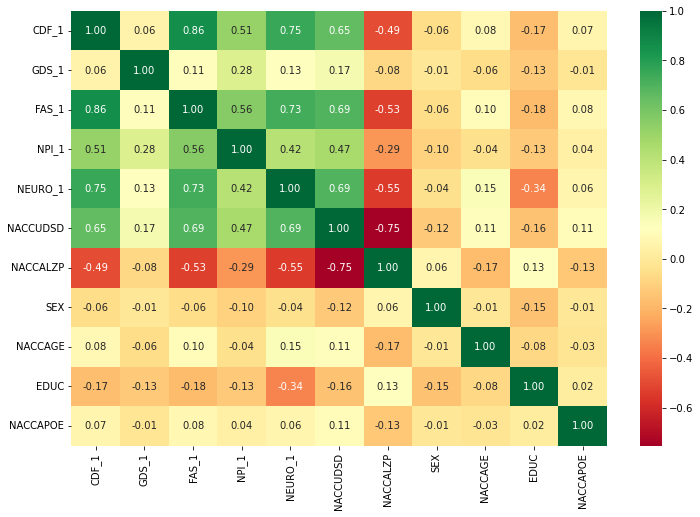

In [5]:
# PCA UDS  UDS is unique for each patient at baseline
assert(len(Counter(uds.groupby('NACCID')['datetime'].count().values)))
uds_pca = pca_transform(uds.drop(['NACCID', 'NACCUDSD', 'NACCADC'], axis=1), uds_dict, 5, pca_thres=0.2)
demo_features = set(uds.columns).intersection(set(uds_dict[uds_dict['Category'] == 'DEMO']['VariableName'].values))
uds_pca = pd.concat([uds_pca, uds[demo_features - set(['NACCADC'])].reset_index(drop=True)], axis=1)
uds_pca['NACCID'] = uds.reset_index()['NACCID']
uds_pca['datetime'] = uds.reset_index()['datetime']
print(uds_pca.shape)

plt.figure(figsize = (12,8))
sns.heatmap(uds_pca.corr(), annot=True, fmt='.2f', cmap='RdYlGn')

Regional gray matter volumes [0.57040551 0.17421349 0.06257161 0.04845621 0.03415285] 2
Regional cortical thicknesses [0.44504453 0.05083131 0.0378131  0.03145076 0.02513382] 1
PET scan data [0.38118094 0.12951085 0.07686328 0.05646614 0.03441651] 2
(2860, 18)


<AxesSubplot:>

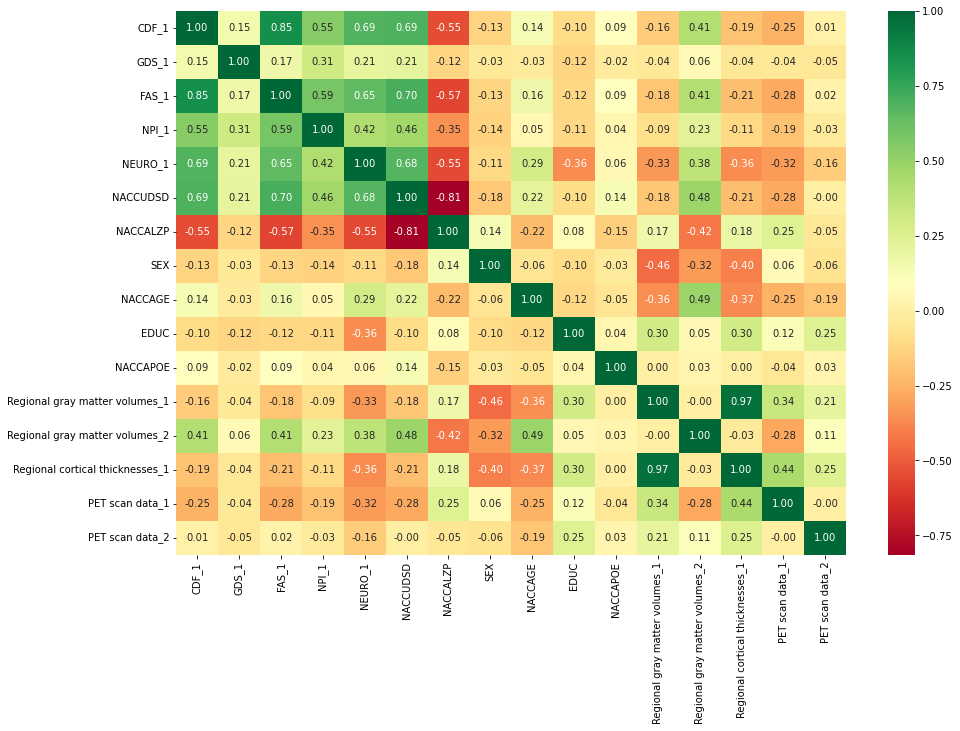

In [6]:
#  PCA MRI data 
assert(len(Counter(mri.groupby('NACCID')['datetime'].count().values)))
mri_pca = pca_transform(mri.drop(['NACCID', 'datetime'], axis=1), mri_dict, 5, pca_thres=0.1)
mri_pca['NACCID'] = mri.reset_index()['NACCID']
uds_mri_merged = uds_pca.merge(mri_pca, on='NACCID', how='inner')
print(uds_mri_merged.shape)

plt.figure(figsize = (15, 10))
sns.heatmap(uds_mri_merged.corr(), annot=True, fmt='.2f', cmap='RdYlGn')

[0.57272228 0.42313746]
(281, 20)


<AxesSubplot:>

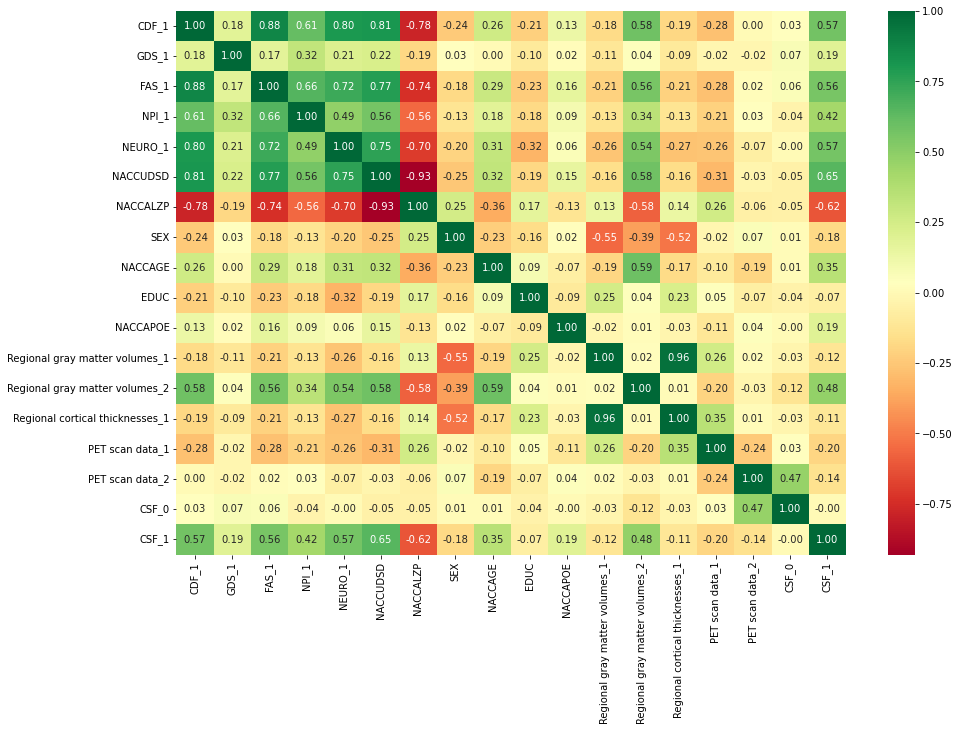

In [7]:
# CSF-patient, duplicates exist for some individuals - should keep the MD features?
csf = csf.groupby('NACCID').mean().reset_index()
# csf_var = csf.drop("NACCADC", axis=1).describe().columns
pca = PCA(n_components=2)
csf_pca = pca.fit_transform(csf.drop(['NACCID', 'NACCADC'], axis=1))
print(pca.explained_variance_ratio_)

csf_pca = pd.DataFrame(csf_pca[:,:2])
csf_pca.columns = ['CSF_{}'.format(i) for i in range(csf_pca.shape[1])]
csf_pca['NACCID'] = csf.reset_index()['NACCID']
uds_mri_cfs_merged = uds_mri_merged.merge(csf_pca, on='NACCID', how='inner')
print(uds_mri_cfs_merged.shape)

plt.figure(figsize = (15, 10))
sns.heatmap(uds_mri_cfs_merged.corr(), annot=True, fmt='.2f', cmap='RdYlGn')

# Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

def print_summary(clf, Xtr, ytr, Xte, yte):
    print("Training Score:  ")
    print(metrics.confusion_matrix(ytr, clf.predict(Xtr)))
    print(metrics.accuracy_score(ytr, clf.predict(Xtr)))
    print()
    print("Testing Score:  ")
    print(metrics.confusion_matrix(yte, clf.predict(Xte)))
    print(metrics.accuracy_score(yte, clf.predict(Xte)))

# UDS Only

In [9]:
print(uds_pca.shape,'\n')

clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)

X_train, X_test, y_train, y_test = train_test_split(uds_pca.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                     uds_pca['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(44740, 13) 

Training Score:  
[[12757   939   113]
 [ 2170  3816   827]
 [   77  1106  9513]]
0.8329395235966537

Testing Score:  
[[5384  416   51]
 [ 950 1637  391]
 [  53  453 4087]]
0.8275964833854865


# UDS v.s. UDS + MRI

## - UDS-Sub

In [10]:
uds_sub = uds_pca[uds_pca['NACCID'].isin(uds_mri_merged['NACCID'])]
print(uds_sub.shape,'\n')

clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)

X_train, X_test, y_train, y_test = train_test_split(uds_sub.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                    uds_sub['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(2860, 13) 

Training Score:  
[[1109   55    5]
 [ 154  258   43]
 [   5   66  307]]
0.8361638361638362

Testing Score:  
[[462  35   0]
 [ 57 109  15]
 [  0  33 147]]
0.8368298368298368


## - UDS + MRI

In [11]:
print(uds_mri_merged.shape,'\n')

clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)

X_train, X_test, y_train, y_test = train_test_split(uds_mri_merged.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                    uds_mri_merged['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(2860, 18) 

Training Score:  
[[1106   58    5]
 [ 152  260   43]
 [   4   69  305]]
0.8346653346653347

Testing Score:  
[[464  33   0]
 [ 51 123   7]
 [  0  29 151]]
0.8601398601398601


# UDS + MRI + CSF
## - UDS-sub

In [12]:
uds_sub = uds_pca[uds_pca['NACCID'].isin(uds_mri_cfs_merged['NACCID'])]
print(uds_sub.shape,'\n')

clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)
X_train, X_test, y_train, y_test = train_test_split(uds_sub.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                    uds_sub['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(281, 13) 

Training Score:  
[[120   1   0]
 [ 10  15   3]
 [  1   3  43]]
0.9081632653061225

Testing Score:  
[[52  2  0]
 [ 4  5  6]
 [ 1  0 15]]
0.8470588235294118


/home/hanweny/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## - UDS + MRI

In [13]:
uds_mri_sub = uds_mri_merged[uds_mri_merged['NACCID'].isin(uds_mri_cfs_merged['NACCID'])]
print(uds_mri_sub.shape,'\n')
clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)
X_train, X_test, y_train, y_test = train_test_split(uds_mri_sub.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                    uds_mri_sub['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(281, 18) 

Training Score:  
[[119   2   0]
 [  8  18   2]
 [  1   4  42]]
0.9132653061224489

Testing Score:  
[[51  3  0]
 [ 4  4  7]
 [ 1  1 14]]
0.8117647058823529


/home/hanweny/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## - UDS + MRI + CSF

In [14]:
print(uds_mri_cfs_merged.shape,'\n')

clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)
X_train, X_test, y_train, y_test = train_test_split(uds_mri_cfs_merged.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                    uds_mri_cfs_merged['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(281, 20) 

Training Score:  
[[118   3   0]
 [ 10   4  14]
 [  4   1  42]]
0.8367346938775511

Testing Score:  
[[54  0  0]
 [10  0  5]
 [ 1  0 15]]
0.8117647058823529


/home/hanweny/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
